In [1]:
import sys
sys.path.append("/home/prml/chanyoung/Trainer")

In [2]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
import os
from sklearn.model_selection import train_test_split
from util.basic_util import seed_everything

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import albumentations as A
from torcheval.metrics import MulticlassAccuracy, MulticlassF1Score, MulticlassRecall, MulticlassPrecision
from sklearn.preprocessing import LabelEncoder

# from trainer import Trainer
from trainer.trainerAngular import Trainer_ang
from trainer.trainer import Trainer

from _Project.ExtraNode.preprocess import *
# from dataset.classificationDataset import ClassificationDataset
from loss.angularLoss import AngularPenaltySMLoss
from model.extraNodeMdoel import *

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# seed_everything(17)

# Dataset

In [7]:
from torch.utils.data import Dataset
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch

class ClassificationDataset(Dataset):
    def __init__(self, img_paths, labels, resize, transforms=None, feature_extractor=None):
        self.img_paths = img_paths
        self.labels = labels
        self.feature_extractor = feature_extractor
        
        if transforms is None and feature_extractor is None:
            self.transforms = A.Compose([
                A.Resize(resize, resize),
                # A.GaussNoise(p=1, var_limit=(10, 50)),
                A.HorizontalFlip(p=0.5),
                A.Normalize(),
                ToTensorV2()
            ])
        elif transforms is None:
            self.transforms = A.Compose([
                A.Resize(resize, resize),
                A.HorizontalFlip(p=0.5),
                A.Normalize()
            ])
        else:
            self.transforms = transforms

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        image = cv2.imread(img_path)
        
        
        # kernel = cv2.getGaborKernel((21,21), 5, 1, 10, 1, 0, cv2.CV_32F)
        # # kernel /= math.sqrt((kernel * kernel).sum())
        # image = cv2.filter2D(image, -1, kernel)
        
        
        if image is None:
            print(img_path)
        
        image = self.transforms(image=image)['image']
        
        if self.feature_extractor is not None:
            encoded_inputs = self.feature_extractor(image, return_tensors="pt")
            image = encoded_inputs['pixel_values'].squeeze_()
                
        
        if self.labels is not None:
            label = self.labels[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_paths)

# Make test dataset & dataloader

In [8]:
polyp_train_df = pd.read_csv("/home/prml/chanyoung/Trainer/_Project/ExtraNode/gachon_polyp_train.csv")
polyp_le = LabelEncoder()
polyp_le.fit(polyp_train_df["class"].values)
polyp_test_df = pd.read_csv("/home/prml/chanyoung/Trainer/_Project/ExtraNode/gachon_polyp_test.csv")
polyp_test_df["class"] = polyp_le.transform(polyp_test_df["class"].values)

polyp_test_dataset = ClassificationDataset(polyp_test_df["filepath"].values, polyp_test_df["class"].values, 224)
polyp_test_loader = DataLoader(polyp_test_dataset, batch_size = 1, shuffle=False, num_workers=0)

In [9]:
xray_train_df = pd.read_csv("/home/prml/chanyoung/Trainer/_Project/ExtraNode/gachon_covid_xray_train.csv")
xle = LabelEncoder()
xle.fit(xray_train_df["class"].values)
xray_test_df = pd.read_csv("/home/prml/chanyoung/Trainer/_Project/ExtraNode/gachon_covid_xray_val.csv")
xray_test_df["class"] = xle.transform(xray_test_df["class"].values)

xray_test_dataset = ClassificationDataset(xray_test_df["filepath"].values, xray_test_df["class"].values, 224)
xray_test_loader = DataLoader(xray_test_dataset, batch_size = 2, shuffle=False, num_workers=0)

In [10]:
df = read_csv("/home/prml/chanyoung/Trainer/_Project/ExtraNode/10person.csv")
    
# face_train_df, face_test_df, _, _ = train_test_split(df, df['class'].values, test_size=0.1, random_state=17)
# face_train_df, face_val_df, _, _ = train_test_split(face_train_df, face_train_df['class'].values, test_size=0.2, random_state=17)

face_le = LabelEncoder()
face_le.fit(df["class"].values)

df["class"] = face_le.transform(df["class"].values)

face_test_dataset = ClassificationDataset(df["filepath"].values, df["class"].values, 224)
face_test_loader = DataLoader(face_test_dataset, batch_size = 2, shuffle=False, num_workers=0)
    

# Polyp Confusiton Matrix

/home/prml/anaconda3/envs/chanyoung/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/prml/anaconda3/envs/chanyoung/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


requires_grad of parameters of Sub_node -> False
requires_grad of parameters of Sub_node -> False


100%|██████████| 400/400 [00:06<00:00, 60.90it/s] 


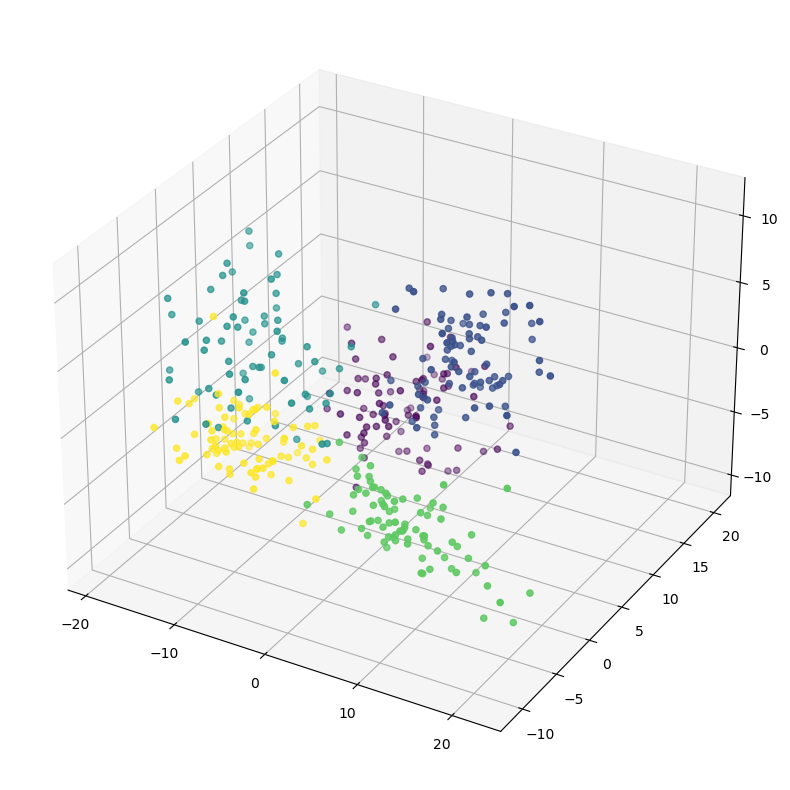

acc: 0.885 recall: 0.885, precsion: 0.8844521190738929 f1: 0.8838778875470922


100%|██████████| 400/400 [00:05<00:00, 70.44it/s] 


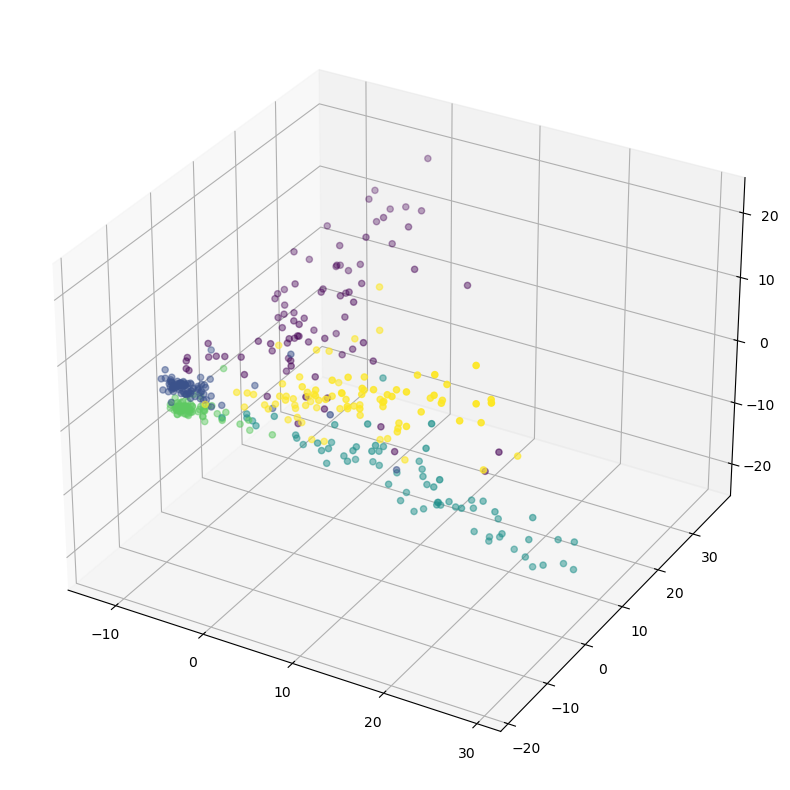

acc: 0.8025 recall: 0.8025, precsion: 0.8014205981102412 f1: 0.8008623113783118


100%|██████████| 400/400 [00:05<00:00, 70.77it/s]


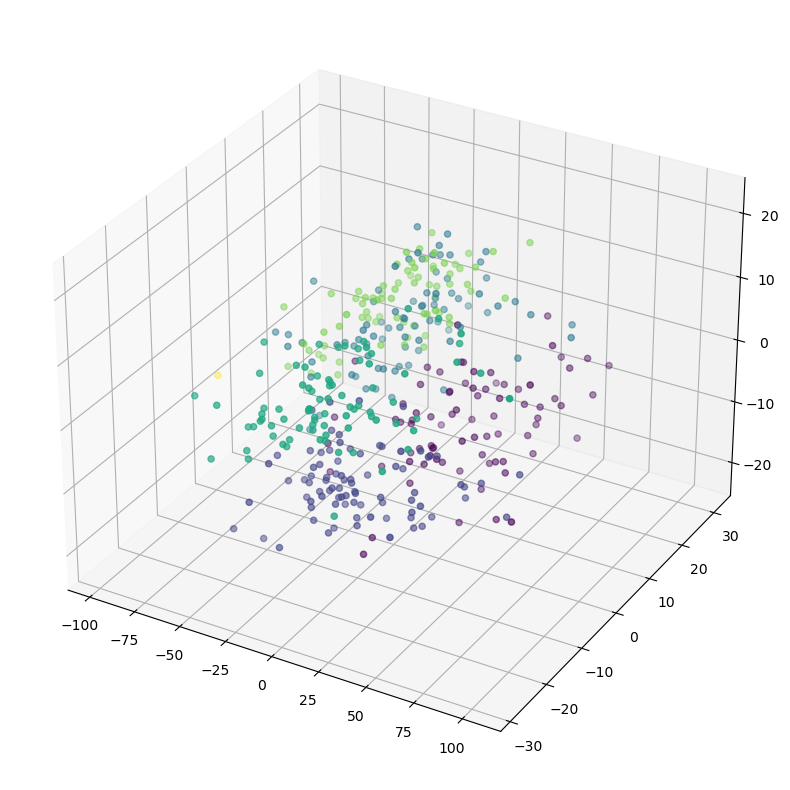

/home/prml/anaconda3/envs/chanyoung/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc: 0.8925 recall: 0.74375, precsion: 0.7455506513339863 f1: 0.7444434332291174


100%|██████████| 400/400 [00:05<00:00, 68.96it/s]


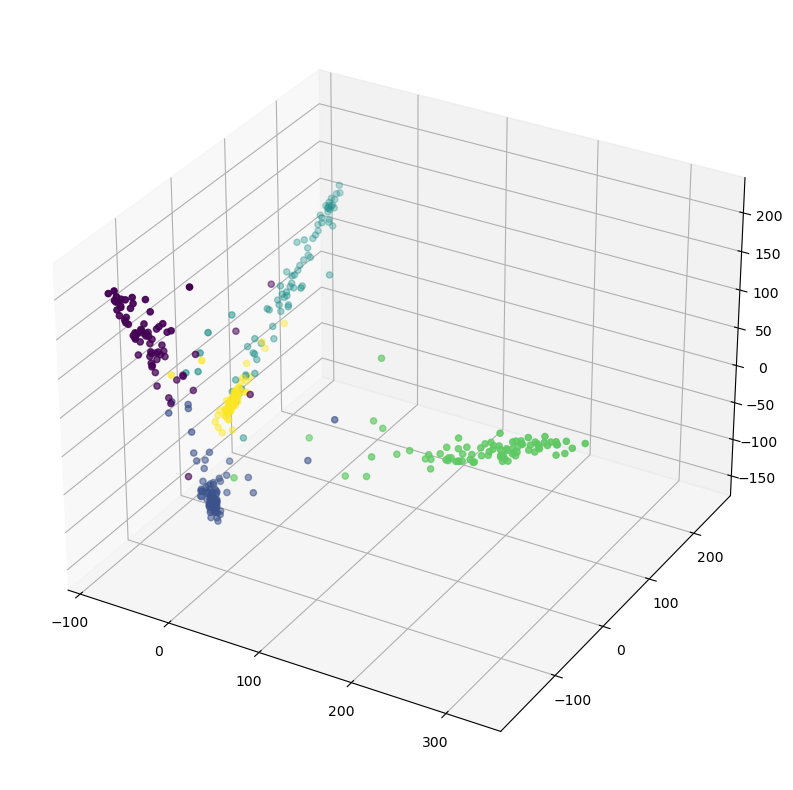

acc: 0.8525 recall: 0.8525, precsion: 0.8520272568972631 f1: 0.8513724929315154


In [11]:
n = len(polyp_test_df['class'].unique())
model_pt_path = "/home/prml/chanyoung/Trainer/_RESULT/ExtraNodeReport_230627/polyp"
models = {EfficientNet_Normal(n):os.path.join(model_pt_path, "eff_normal.pt"),
         EfficientNet_Arc(n):os.path.join(model_pt_path, "eff_arc.pt"),
         EfficientNet_ExtraNode(n):os.path.join(model_pt_path, "eff_extra_node.pt"),
         EfficientNet_ArcExtraNode(n):os.path.join(model_pt_path, "eff_arc_extra.pt")}

for model, path in models.items():
    # read saved weights
    try:
        model.load_state_dict(torch.load(path))
    except:
        state_dict = torch.load(path)
        # create new OrderedDict that does not contain `module.`
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)

    model.to(device)
    model.eval()

    y_true = []
    y_pred = []
    feature_list = []
    
    for images, labels in tqdm(polyp_test_loader):
        images = images.to(device)
        
        y_true.extend(labels.numpy())
        labels = labels.to(device)
        
        features, outputs=model(images, labels)
        
        feature_list.extend(features.detach().cpu().numpy())
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())  
    
    
    pca = PCA(n_components=3)
    threeD = pca.fit_transform(feature_list)
    threeD = np.array(threeD)
    
    pca2 = PCA(n_components=2)
    twoD = pca.fit_transform(feature_list)
    twoD = np.array(twoD)
    
    
    # plt.figure()
    # plt.scatter(x=twoD[:,0], y=twoD[:,1], c=y_pred)
    # plt.show()
    #===================================================================
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(threeD[:,0], threeD[:,1], threeD[:,2], c=y_pred, s=20)
    plt.show()
    #====================================================================
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average="macro")
    precision = precision_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    
    print(f"acc: {acc} recall: {recall}, precsion: {precision} f1: {f1}")
    
    # cf_matrix = confusion_matrix(y_true, y_pred)
    # df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
    # plt.figure(figsize = (12,7))
    # sn.heatmap(df_cm, annot=True)
    # plt.show('')

# Xray

In [13]:
n = len(xray_test_df['class'].unique())
model_pt_path = "/home/prml/chanyoung/Trainer/_RESULT/ExtraNodeReport/xray"
models = {EfficientNet_Normal(n):os.path.join(model_pt_path, "eff__normal.pt"),
         EfficientNet_Arc(n):os.path.join(model_pt_path, "eff__arc.pt"),
         EfficientNet_ExtraNode(n):os.path.join(model_pt_path, "eff__extra_node.pt"),
         EfficientNet_ArcExtraNode(n):os.path.join(model_pt_path, "eff__arc_extra.pt")}

for model, path in models.items():
    # read saved weights
    try:
        model.load_state_dict(torch.load(path))
    except:
        state_dict = torch.load(path)
        # create new OrderedDict that does not contain `module.`
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)

    model.to(device)
    model.eval()

    y_true = []
    y_pred = []
    feature_list = []
    
    for images, labels in tqdm(polyp_test_loader):
        images = images.to(device)
        
        y_true.extend(labels.numpy())
        labels = labels.to(device)
        
        features, outputs=model(images, labels)
        
        # feature_list.extend(features.detach().cpu().numpy())
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())  
    
    
    # pca = PCA(n_components=3)
    # threeD = pca.fit_transform(feature_list)
    # threeD = np.array(threeD)
    
    # pca2 = PCA(n_components=2)
    # twoD = pca.fit_transform(feature_list)
    # twoD = np.array(twoD)
    
    
    # plt.figure()
    # plt.scatter(x=twoD[:,0], y=twoD[:,1], c=y_pred)
    # plt.show()
    #===================================================================
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(threeD[:,0], threeD[:,1], threeD[:,2], c=y_pred, s=20)
    # plt.show()
    #====================================================================
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average="macro")
    precision = precision_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    
    print(f"acc: {acc} recall: {recall}, precsion: {precision} f1: {f1}")
    
    # cf_matrix = confusion_matrix(y_true, y_pred)
    # df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
    # plt.figure(figsize = (12,7))
    # sn.heatmap(df_cm, annot=True)
    # plt.show()

requires_grad of parameters of Sub_node -> False
requires_grad of parameters of Sub_node -> False


100%|██████████| 400/400 [00:05<00:00, 71.88it/s] 
/home/prml/anaconda3/envs/chanyoung/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc: 0.195 recall: 0.195, precsion: 0.03939393939393939 f1: 0.06554621848739496


  0%|          | 0/400 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Face

In [14]:
n = len(df['class'].unique())
model_pt_path = "/home/prml/chanyoung/Trainer/_RESULT/ExtraNodeReport_230627/10person"
models = {EfficientNet_Normal(n):os.path.join(model_pt_path, "eff_normal.pt"),
         EfficientNet_Arc(n):os.path.join(model_pt_path, "eff_arc.pt"),
         EfficientNet_ExtraNode(n):os.path.join(model_pt_path, "eff_extra_node.pt"),
         EfficientNet_ArcExtraNode(n):os.path.join(model_pt_path, "eff_arc_extra.pt")}

for model, path in models.items():
    # read saved weights
    try:
        model.load_state_dict(torch.load(path))
    except:
        state_dict = torch.load(path)
        # create new OrderedDict that does not contain `module.`
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)

    model.to(device)
    model.eval()

    y_true = []
    y_pred = []
    feature_list = []
    
    for images, labels in tqdm(polyp_test_loader):
        images = images.to(device)
        
        y_true.extend(labels.numpy())
        labels = labels.to(device)
        
        features, outputs=model(images, labels)
        
        # feature_list.extend(features.detach().cpu().numpy())
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())  
    
    
    # pca = PCA(n_components=3)
    # threeD = pca.fit_transform(feature_list)
    # threeD = np.array(threeD)
    
    # pca2 = PCA(n_components=2)
    # twoD = pca.fit_transform(feature_list)
    # twoD = np.array(twoD)
    
    
    # plt.figure()
    # plt.scatter(x=twoD[:,0], y=twoD[:,1], c=y_pred)
    # plt.show()
    #===================================================================
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(threeD[:,0], threeD[:,1], threeD[:,2], c=y_pred, s=20)
    # plt.show()
    #====================================================================
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average="macro")
    precision = precision_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    
    print(f"acc: {acc} recall: {recall}, precsion: {precision} f1: {f1}")
    
    # cf_matrix = confusion_matrix(y_true, y_pred)
    # df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
    # plt.figure(figsize = (12,7))
    # sn.heatmap(df_cm, annot=True)
    # plt.show()

/home/prml/anaconda3/envs/chanyoung/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/prml/anaconda3/envs/chanyoung/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


requires_grad of parameters of Sub_node -> False
requires_grad of parameters of Sub_node -> False


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
